# <center>Organizaci&oacute;n de Datos</center>
#### <center>C&aacute;tedra Ing. Rodriguez, Juan Manuel </center>

## <center>Trabajo Práctico 1 : Propiedades en Venta</center>
## <center>Parte 4</center>
### <center> Grupo 22 </center>
### <center> Integrantes: </center>
##### <center> Federico Martin Forte,  Francisco Sobral,  Ian Klaus von der Heyde,  Juan Pablo Aschieri,  Joaquin Rivero  </center>

# Carga de Datos y librerías

In [3]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gp

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.metrics import silhouette_score

from pyclustertend import hopkins
from yellowbrick.cluster import SilhouetteVisualizer

from IPython.display import Image
from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics

In [4]:
viviendas_caba_train=pd.read_csv('./Datasets/viviendas_caba_train.csv').copy()
viviendas_caba_test=pd.read_csv('./Datasets/viviendas_caba_test.csv').copy()
viviendas_caba=pd.read_csv('./Datasets/viviendas_caba.csv').copy()

pca_df=pd.read_csv('./Datasets/pca_properati_argentina_2021.csv').copy()

poly = gp.read_file(r'./Datasets/barrios_procesados.geojson')

# 2. Regresión

## Modelo 1: KNN

### Dataset completo:

Como en el parte 1 ya limpiamos los valores atípicos no tenemos que hacerlo nuevamente para esta parte

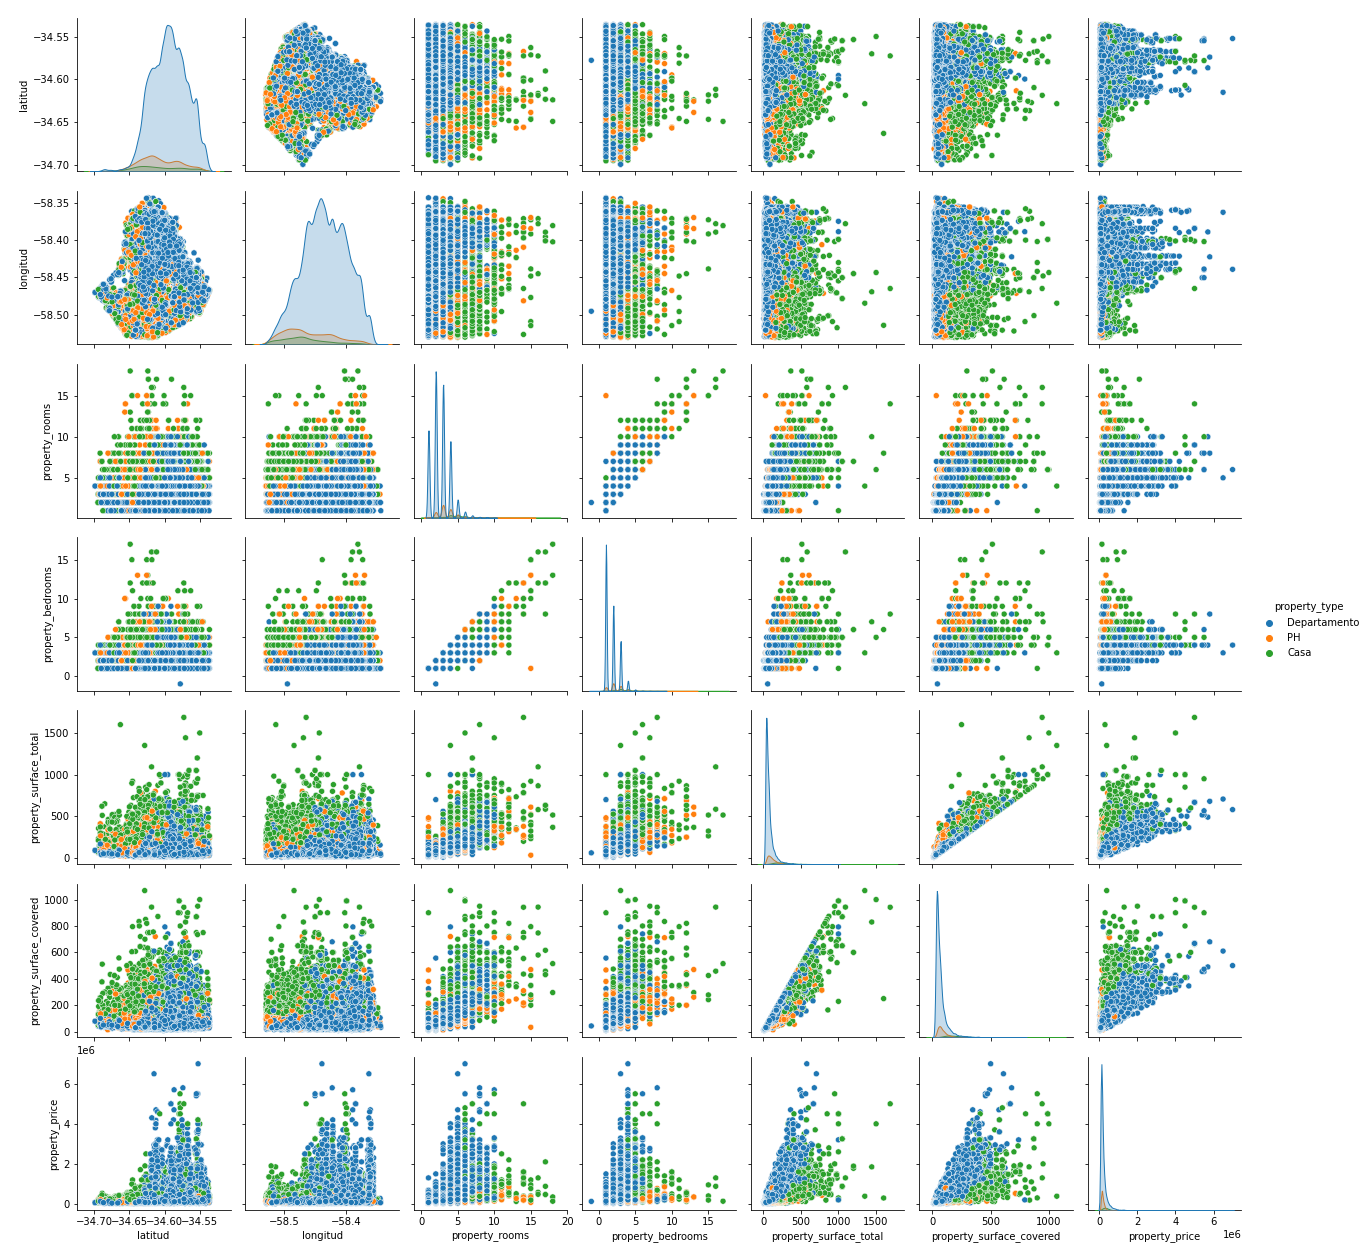

In [13]:
Image(filename = './Figures/paiplot_dataset_procesado.png', width=1500, height=1500)

**Realizamos Encoding**

para variable property_type y barrio

In [6]:
from sklearn.preprocessing import LabelEncoder

viviendas_caba_encoded = viviendas_caba.copy()
viviendas_caba_encoded['property_type'] = LabelEncoder().fit_transform(viviendas_caba['property_type'])
viviendas_caba_encoded['barrio'] = LabelEncoder().fit_transform(viviendas_caba['barrio'])
viviendas_caba_encoded.head(2)

,start_date,end_date,latitud,longitud,barrio,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title,geometry
0,2021-09-09,2021-09-26,-34.637319,-58.361124,7,1,3.0,2.0,58.0,55.0,82900.0,VENTA TRES AMBIENTES LA BOCA PISO ALTO,POINT (-58.361124 -34.6373187)
1,2021-09-09,2021-09-28,-34.628647,-58.361871,7,1,4.0,3.0,70.0,70.0,99000.0,Departamento - 4 Ambientes - Catalinas Sur,POINT (-58.3618713 -34.6286465)


In [19]:
"""pairplot_fig = sns.pairplot(viviendas_caba_train_encoded, hue='property_type')"""

"pairplot_fig = sns.pairplot(viviendas_caba_train_encoded, hue='property_type')"

In [8]:
#Heatmap correlación
viviendas_caba_encoded.corr().style.background_gradient(cmap='coolwarm')

,latitud,longitud,barrio,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price
latitud,1.000000,-0.141103,0.016952,-0.065060,-0.026360,-0.028009,0.021501,0.040684,0.165261
longitud,-0.141103,1.000000,-0.254398,-0.073198,0.009903,0.007454,-0.004242,0.047954,0.126130
barrio,0.016952,-0.254398,1.000000,0.037220,-0.017533,-0.022601,0.016797,0.000657,-0.005310
property_type,-0.065060,-0.073198,0.037220,1.000000,-0.065310,-0.072324,-0.170745,-0.198191,-0.132513
property_rooms,-0.026360,0.009903,-0.017533,-0.065310,1.000000,0.926325,0.757079,0.770356,0.523442
property_bedrooms,-0.028009,0.007454,-0.022601,-0.072324,0.926325,1.000000,0.724889,0.736133,0.483020
property_surface_total,0.021501,-0.004242,0.016797,-0.170745,0.757079,0.724889,1.000000,0.954240,0.723027
property_surface_covered,0.040684,0.047954,0.000657,-0.198191,0.770356,0.736133,0.954240,1.000000,0.776274
property_price,0.165261,0.126130,-0.005310,-0.132513,0.523442,0.483020,0.723027,0.776274,1.000000


**Correlación**

gracias al pairplot y a la matriz de correlacion vemos que el precio está más relacionado con la superficie total y cubierta, por lo que las elegimos como variables predictoras (aunque luego nos dimos cuenta que al agregar property_rooms y property_bedrooms como variables predictoras mejoran nuestras métricas)

In [9]:
#selecciono variables regresoras y a predecir
X_train = viviendas_caba_train[['property_surface_total', 'property_surface_covered', 'property_rooms', 'property_bedrooms']]
X_test = viviendas_caba_test[['property_surface_total', 'property_surface_covered', 'property_rooms', 'property_bedrooms']]
y_train = viviendas_caba_train.property_price
y_test = viviendas_caba_test.property_price

In [10]:
#Heatmap correlación
X_train.corr().style.background_gradient(cmap='coolwarm')

,property_surface_total,property_surface_covered,property_rooms,property_bedrooms
property_surface_total,1.000000,0.954711,0.758225,0.726663
property_surface_covered,0.954711,1.000000,0.771415,0.737603
property_rooms,0.758225,0.771415,1.000000,0.926374
property_bedrooms,0.726663,0.737603,0.926374,1.000000


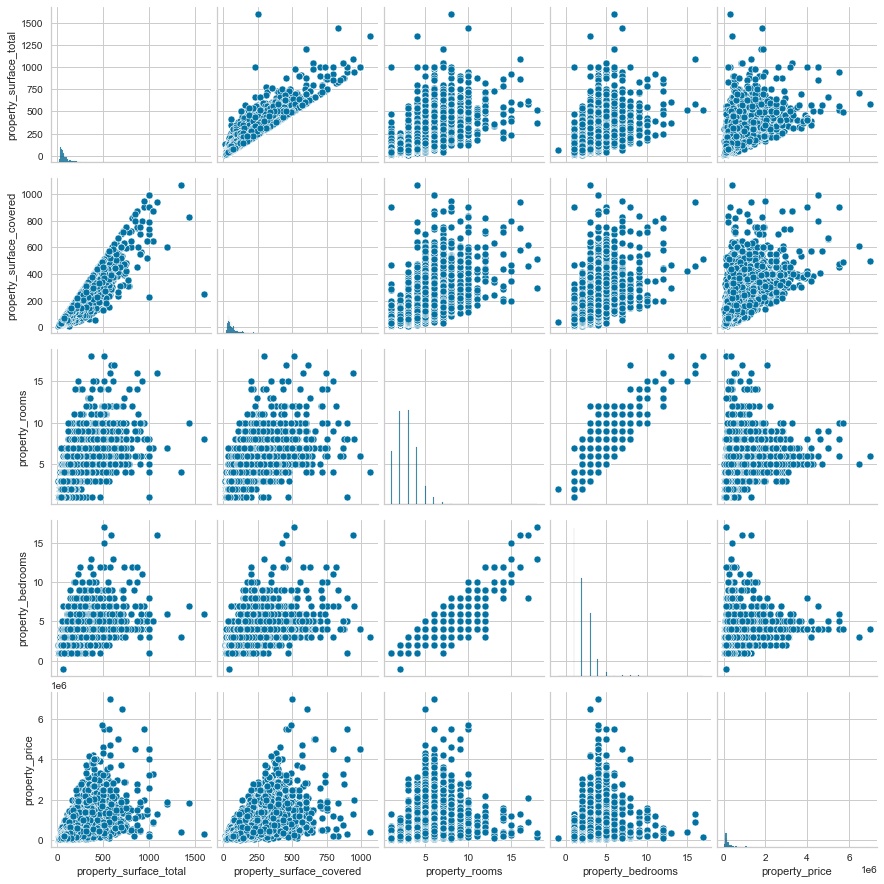

In [14]:
#Grafico de a pares incluyendo variable a predecir
xy_train_sin_outliers = pd.concat([X_train, y_train], axis=1)
sns.pairplot(xy_train_sin_outliers)

**Normalizado de datos**

Decidimos no normalizar ya que al hacerlo empeoran nuestras métricas levemente

In [15]:
"""from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
#scalling the training set
X_train = sc.fit_transform(X_train)
#scalling the test set
X_test = sc.fit_transform(X_test)"""

'from sklearn.preprocessing import StandardScaler\nsc = StandardScaler()\n#scalling the training set\nX_train = sc.fit_transform(X_train)\n#scalling the test set\nX_test = sc.fit_transform(X_test)'

**Optimizamos los parámetros usando random search cross validation**

In [11]:
from sklearn.model_selection import RandomizedSearchCV

#Grilla de Parámetros
params_grid={ 'n_neighbors':range(1,30), 
              'weights':['distance','uniform'],
              'algorithm':['ball_tree', 'kd_tree', 'brute'],
              'metric':['euclidean','manhattan','chebyshev']
             }

#Clasificador KNN
knn_regressor=KNeighborsRegressor()

#Random Search con 5 Folds y 5 iteraciones
rand = RandomizedSearchCV(knn_regressor, params_grid, cv=5, scoring='r2', n_iter=5, random_state=5)

rand.fit(X_train, y_train)
rand.cv_results_['mean_test_score']

array([0.7371343 , 0.66655369, 0.74343797, 0.68307724, 0.71327894])

In [12]:
#Mejores hiperparametros
print(rand.best_params_)
#Mejor métrica
print(rand.best_score_)

{'weights': 'distance', 'n_neighbors': 27, 'metric': 'euclidean', 'algorithm': 'brute'}
0.7434379699509461


In [15]:
# Performance
performance = pd.DataFrame({'Valor Real': y_test,
                            'Prediccion': y_pred.round(),
                            'Error': y_test - y_pred.round()})
# View
performance.head()

,Valor Real,Prediccion,Error
0,140000.0,110544.0,29456.0
1,69900.0,113526.0,-43626.0
2,75900.0,71511.0,4389.0
3,315000.0,163894.0,151106.0
4,79000.0,78048.0,952.0


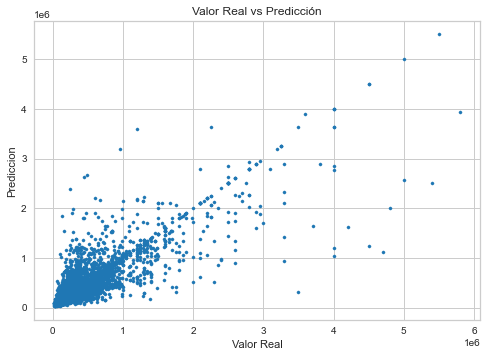

In [16]:
scatter_real_predict = performance.plot.scatter(x="Valor Real", y="Prediccion", s=10, c='tab:blue').set(title="Valor Real vs Predicción",xlabel='Valor Real',ylabel='Prediccion') 


**Métricas sobre test**

In [17]:
#Mejor estimador
best_knn_regressor = rand.best_estimator_

#Predicción con mejor estimador
y_pred=best_knn_regressor.predict(X_test)

#Coef. de Determinación R2
from sklearn.metrics import r2_score
print(f'Coef. de Determinación R2: {r2_score(y_test, y_pred)}')

#Mean Square Error
mse = metrics.mean_squared_error(
        y_true  = y_test,
        y_pred  = y_pred,
        squared = True
       )

print(f"El error (mse) de test es: {mse}")

#Root Mean Square Error
rmse = metrics.mean_squared_error(
        y_true  = y_test,
        y_pred  = y_pred,
        squared = False
       )

print(f"El error (rmse) de test es: {rmse}")

Coef. de Determinación R2: 0.7568732968161866
El error (mse) de test es: 22737600843.350178
El error (rmse) de test es: 150789.92288395858


**Métricas sobre train**

In [18]:
#Mejor estimador
best_knn_regressor = rand.best_estimator_

#Predicción con mejor estimador
y_pred_train = best_knn_regressor.predict(X_train)

#Coef. de Determinación R2
from sklearn.metrics import r2_score
print(f'Coef. de Determinación R2: {r2_score(y_train, y_pred_train)}')

#Mean Square Error
mse = metrics.mean_squared_error(
        y_true  = y_train,
        y_pred  = y_pred_train,
        squared = True
       )

print(f"El error (mse) de test es: {mse}")

#Root Mean Square Error
rmse = metrics.mean_squared_error(
        y_true  = y_train,
        y_pred  = y_pred_train,
        squared = False
       )

print(f"El error (rmse) de test es: {rmse}")

Coef. de Determinación R2: 0.9493853584346963
El error (mse) de test es: 4421326281.328147
El error (rmse) de test es: 66493.05438410952


**Conclusiones KNN**

¿Cuántos
folds utilizaron? ¿Qué métrica consideran adecuada para buscar los parámetros?...

utilizamos 5 folds porque............................................................



+ Coeficiente de determinación 𝑹^𝟐: me dice cuanto explica la variabilidad del problema (0 explica poco, 1 explica mucho)
+ MSE:(Error Cuadrático Medio (Mean Squared Error)): Medida de qué tan cercana es la recta de regresión a los puntos que representan los datos. Mientras más chico más cerca está nuestro modelo de los datos reales. Al ser un valor elevado al cuadrado, es sensible a valores de diferencias grandes.
+ RMSE: es la raíz cuadrada de MSE, es mas fácil de interpretar ya que estará en las mismas unidades (dólares) que las del problema


EXPOLICAR CADA METRICA

### Dataset con reducción de dimensionalidad:

Como en el parte 1 ya limpiamos los valores atípicos no tenemos que hacerlo nuevamente para esta parte

In [23]:
pca_df.head(2)
pca_df_con_precio = pd.concat([pca_df, viviendas_caba.property_price], axis=1)
pca_df_con_precio.head(2)

,cp_1,cp_2,cp_3,cp_4,property_price
0,-0.426588,2.567561,0.337390,-0.485601,82900.0
1,0.526527,2.397696,0.141711,-1.263580,99000.0


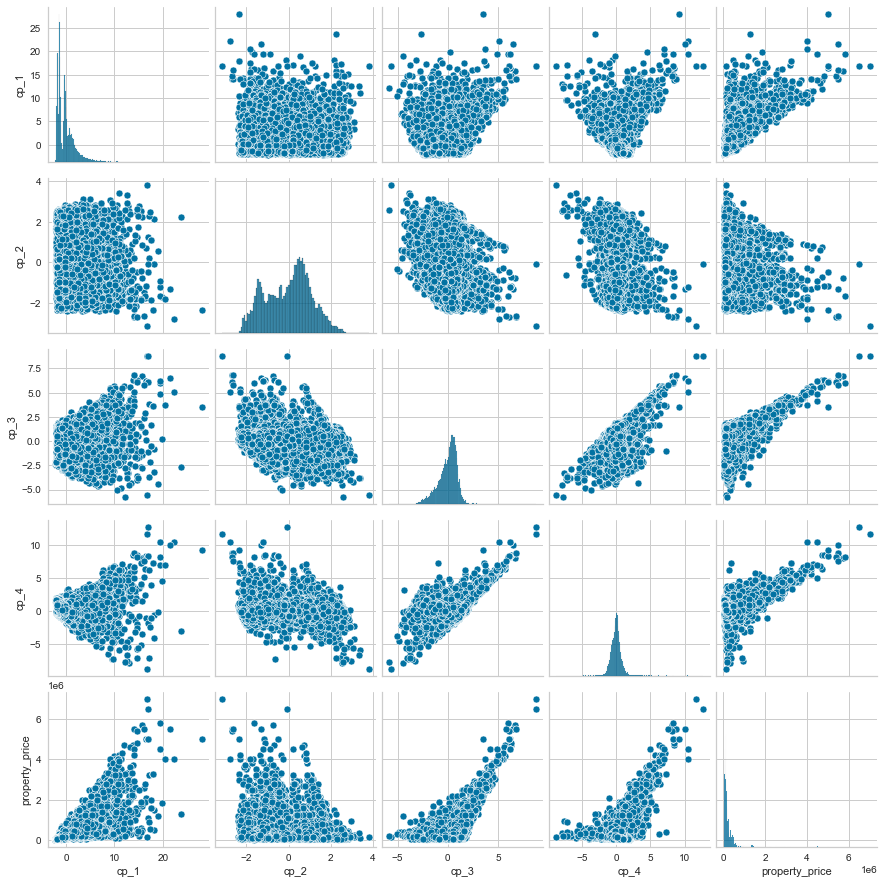

In [24]:
pairplot_fig = sns.pairplot(pca_df_con_precio)

In [25]:
#Heatmap correlación
pca_df_con_precio.corr().style.background_gradient(cmap='coolwarm')

,cp_1,cp_2,cp_3,cp_4,property_price
cp_1,1.000000,0.000000,-0.000000,-0.000000,0.782007
cp_2,0.000000,1.000000,-0.000000,-0.000000,-0.089179
cp_3,-0.000000,-0.000000,1.000000,0.000000,0.369113
cp_4,-0.000000,-0.000000,0.000000,1.000000,0.381816
property_price,0.782007,-0.089179,0.369113,0.381816,1.000000


**Correlación**

gracias al pairplot y a la matriz de correlacion vemos que el precio está más relacionado con CP1, por lo que la elegimos como variable predictora

In [26]:
#selecciono variables regresoras y a predecir
X = pca_df[['cp_1', 'cp_3', 'cp_4']]
y = viviendas_caba.property_price

#Separacion Train/test  (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=12)

In [27]:
#Heatmap correlación
X_train.corr().style.background_gradient(cmap='coolwarm')

,cp_1,cp_3,cp_4
cp_1,1.000000,-0.002793,0.000953
cp_3,-0.002793,1.000000,-0.002993
cp_4,0.000953,-0.002993,1.000000


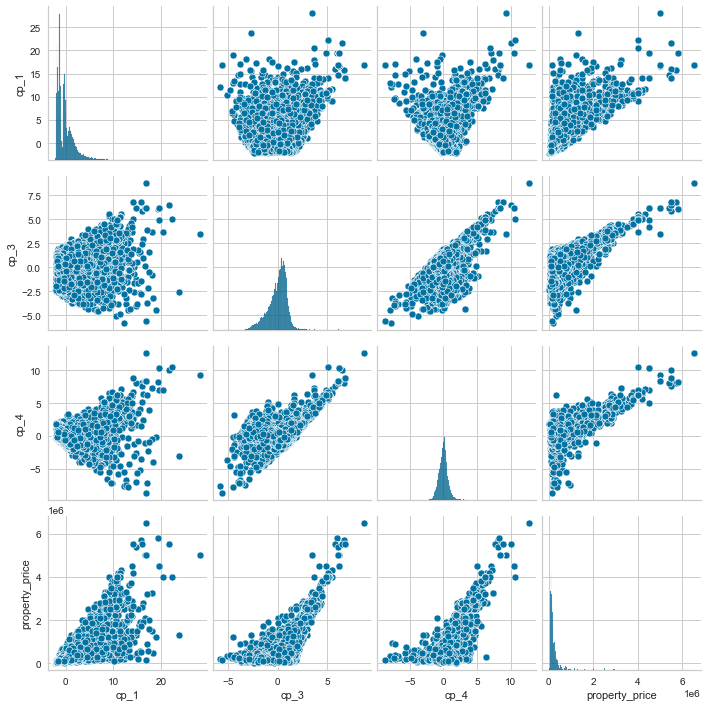

In [28]:
#Grafico de a pares incluyendo variable a predecir
xy_train_sin_outliers = pd.concat([X_train, y_train], axis=1)
sns.pairplot(xy_train_sin_outliers)

**Normalizado de datos**

Decidimos no normalizar ya que al hacerlo empeoran nuestras métricas levemente

In [29]:
"""from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
#scalling the training set
X_train = sc.fit_transform(X_train)
#scalling the test set
X_test = sc.fit_transform(X_test)"""

'from sklearn.preprocessing import StandardScaler\nsc = StandardScaler()\n#scalling the training set\nX_train = sc.fit_transform(X_train)\n#scalling the test set\nX_test = sc.fit_transform(X_test)'

**Optimizamos los parámetros usando random search cross validation**

In [30]:
from sklearn.model_selection import RandomizedSearchCV

#Grilla de Parámetros
params_grid={ 'n_neighbors':range(1,30), 
              'weights':['distance','uniform'],
              'algorithm':['ball_tree', 'kd_tree', 'brute'],
              'metric':['euclidean','manhattan','chebyshev']
             }

#Clasificador KNN
knn_regressor=KNeighborsRegressor()

#Random Search con 10 Folds y 10 iteraciones
rand = RandomizedSearchCV(knn_regressor, params_grid, cv=10, scoring='r2', n_iter=10, random_state=5)

rand.fit(X_train, y_train)
rand.cv_results_['mean_test_score']

array([0.97032747, 0.96380218, 0.96449184, 0.9588558 , 0.97182415,
       0.9646    , 0.96335201, 0.97085339, 0.97155853, 0.97017703])

In [31]:
#Mejores hiperparametros
print(rand.best_params_)
#Mejor métrica
print(rand.best_score_)

{'weights': 'distance', 'n_neighbors': 22, 'metric': 'euclidean', 'algorithm': 'brute'}
0.9718241516215006


In [32]:
#Mejor estimador
best_knn_regressor = rand.best_estimator_

#Predicción con mejor estimador
y_pred=best_knn_regressor.predict(X_test)

#Coef. de Determinación R2
from sklearn.metrics import r2_score
print(f'Coef. de Determinación R2: {r2_score(y_test, y_pred)}')

Coef. de Determinación R2: 0.9727767929111575


In [33]:
# Performance
performance = pd.DataFrame({'Valor Real': y_test,
                            'Prediccion': y_pred.round(),
                            'Error': y_test - y_pred})
# View
performance.head()

,Valor Real,Prediccion,Error
53374,85000.0,126683.0,-41682.504717
897,289000.0,271734.0,17265.964624
41973,235000.0,253233.0,-18233.215562
20322,92000.0,102590.0,-10589.832559
84683,270000.0,217749.0,52250.557331


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


[Text(0.5, 1.0, 'Valor Real vs Predicción'),
 Text(0.5, 0, 'Valor Real'),
 Text(0, 0.5, 'Prediccion')]

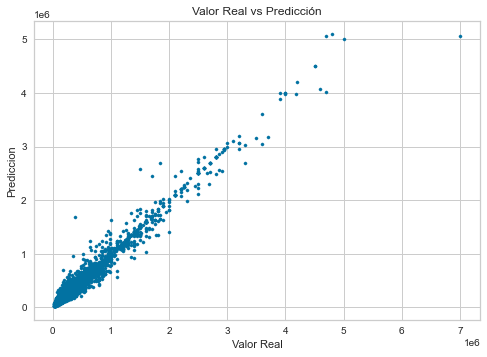

In [34]:
performance.plot.scatter(x="Valor Real", y="Prediccion", s=10).set(title="Valor Real vs Predicción",xlabel='Valor Real',ylabel='Prediccion') 


In [35]:
#Mean Square Error
mse = metrics.mean_squared_error(
        y_true  = y_test,
        y_pred  = y_pred,
        squared = True
       )

print(f"El error (mse) de test es: {mse.round()}")

#Root Mean Square Error
rmse = metrics.mean_squared_error(
        y_true  = y_test,
        y_pred  = y_pred,
        squared = False
       )

print(f"El error (rmse) de test es: {rmse.round()}")

El error (mse) de test es: 2491387174.0
El error (rmse) de test es: 49914.0


Conclusiones KNN

¿Cuántos
folds utilizaron? ¿Qué métrica consideran adecuada para buscar los parámetros?...

EXPOLICAR CADA METRICA

## Modelo 2: XGBoost